# snapjax intro

a quick walkthrough of an inference in Jax and Numpyro for Supernova Cosmology

In [1]:
cd /home/makinen/repositories/fishnets/snia

/home/makinen/repositories/fishnets/snia


## generate some SNIa from JLA seed data
here we've simulated $N=250$ SNIa, so sampling will take a bit longer. $N=50$ is quick enough for debugging.

In [5]:
#@title scratch old script
import matplotlib
import matplotlib
#matplotlib.use('Agg')
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import scipy.stats as ss
import scipy
import scipy.constants as cnst

from astropy import units as u
from astropy.coordinates import SkyCoord

c_light = 299792.0 # Speed of light in km/s
h = 0.72 # Hubble parameter
H_0 = 100.0 # Hubble constant
#M_0 = -19.3 # Intrinsic magnitude
sn1a_variance = 0.16
cmb_variance = 0.04 ** 2.0
cmb_constraint = 1.3 # sum of matter and dark energy density
angular_diameter_constraint = 1408
DA_variance = 45.0 ** 2.0
hubbles_constant = 100

#true_alpha = 0.13
#true_beta = 2.56
intrinsic_dispersion = 0.1
#true_omegam = 0.3
#true_omegade= 0.7

true_x1 = 0
true_c = 0
Rx = 1.0
Rc = 0.1

number_of_sne = 250 #int(sys.argv[6])
distribution_on_sky = "kde"

lc_params_filename = "lc_params.txt"
covariance_filename = "sim_statssys.txt"

#print("simulating %d SNe"%(number_of_sne))
# print("Dipole Value: ", sys.argv[1])
# print("Quadrupole Value: ", sys.argv[2])
# print("LC Params filename: ", sys.argv[3])
# print("Full Covariance filename: ", sys.argv[4])
# print("Distribution on sky: ", sys.argv[5])




def normalise(v):
    norm = np.linalg.norm(v)
    if norm == 0:
       return v
    return v / norm

def get_norm_cartesian(l,b):
    cartesian_form = np.array([np.cos(b)*np.cos(l),np.cos(b)*np.sin(l),np.sin(b)])
    #print("Cartesian Form:",cartesian_form)
    cartesian_form = normalise(cartesian_form)
    return cartesian_form

#Dipole values
dipole_amplitude = 0.0 #float(sys.argv[1])
dipole_l = np.pi/12.0 #15 degrees
dipole_b = np.pi/6.0 #30 degrees
dipole_direction = get_norm_cartesian(dipole_l,dipole_b)

#Quadrupole values
quadrupole_amplitude = 0.0 #float(sys.argv[2])
quadrupole_l = np.pi/8.0 #22.5 degree
quadrupole_b = np.pi/4.0 #45 degrees
quadrupole_direction = get_norm_cartesian(quadrupole_l,quadrupole_b)


def get_dipole(dipole_amplitdue, dipole_direction , sn_direction):
    return (dipole_amplitude * np.dot(dipole_direction, sn_direction))

def get_quadrupole(quadrupole_amplitude, quadrupole_direction, sn_direction):
    return (quadrupole_amplitude * ((3.0 * (np.dot(quadrupole_direction,sn_direction) ** 2.0)) - 1.0)) #m=0 l=2

def generate_covariance_matrix(data):
    cov_data = np.zeros((np.shape(data)[0]*3,np.shape(data)[0]*3)) # Assume diagonal covariance
    for i in range(0,np.shape(data)[0]):
        cov_data[i*3][i*3] = data[i][6] ** 2.0 # Set c value
        cov_data[i*3 + 1][i*3 + 1] = data[i][4] ** 2.0# Set x value
        cov_data[i*3 + 2][i*3 + 2] = data[i][2] ** 2.0# Set mb value
    return cov_data




#####DATA
snarray = []
with open('jla_lcparams.txt') as f:
    for line in f:
        snarray.append([(x) for x in line.split()])
'''
name = [snarray[i][0] for i in range(1,240)]
Zcmb = [float(snarray[i][1]) for i in range(1,240)]
Zhel = [float(snarray[i][2]) for i in range(1,240)]
mb = [float(snarray[i][4]) for i in range(1,240)]
dmb = [float(snarray[i][5]) for i in range(1,240)]
x1 = [float(snarray[i][6]) for i in range(1,240)]
dx1 = [float(snarray[i][7]) for i in range(1,240)]
c = [float(snarray[i][8]) for i in range(1,240)]
dc = [float(snarray[i][9]) for i in range(1,240)]
'''

name = [snarray[i][0] for i in range(1,len(snarray))]
Zcmb = [float(snarray[i][1]) for i in range(1,len(snarray))]
Zhel = [float(snarray[i][2]) for i in range(1,len(snarray))]
mb = [float(snarray[i][4]) for i in range(1,len(snarray))]
dmb = [float(snarray[i][5]) for i in range(1,len(snarray))]
x1 = [float(snarray[i][6]) for i in range(1,len(snarray))]
dx1 = [float(snarray[i][7]) for i in range(1,len(snarray))]
c = [float(snarray[i][8]) for i in range(1,len(snarray))]
dc = [float(snarray[i][9]) for i in range(1,len(snarray))]
ra = [float(snarray[i][16]) for i in range(1,len(snarray))]
dec = [float(snarray[i][17]) for i in range(1,len(snarray))]


#Generate KDE estimate of position DATA

values = np.vstack([ra, dec])
kernel = ss.gaussian_kde(values)

xmin = min(ra)
xmax = max(ra)
ymin = min(dec)
ymax = max(dec)
print(xmin,xmax,ymin,ymax)


X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kernel(positions).T, X.shape)



Zcmb_mean = np.mean(Zcmb)
Zcmb_std = np.std(Zcmb)

# get errors on salt-II from JLA seed data

dmb_mean = np.mean(dmb)
dmb_std = np.std(dmb)

dx1_mean = np.mean(dx1)
dx1_std = np.std(dx1)

dc_mean = np.mean(dc)
dc_std = np.std(dc)

mb_mean = np.mean(mb)
mb_std = np.std(mb)

#x1_mean = true_x1 #np.mean(x1)
#x1_std = Rx #np.std(x1)

#c_mean = true_c #np.mean(c)
#c_std = Rc #np.std(c)

#print(Zcmb_mean, Zcmb_std, dmb_mean, dmb_std, dx1_mean, dx1_std, dc_mean, dc_std)





-55.207462 359.63509 -66.485085 79.03174


In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
#import torch
import jax
from jax import lax
import jax_cosmo as jc
import scipy.constants as cnst
import scipy.stats as ss

import matplotlib.pyplot as plt

import numpy as np
import numpyro
import numpyro.distributions as dist

In [3]:
#@title plot code
def make_plot(inputs):
  sim_z, sim_mb, sim_dmb, sim_x1, \
     sim_dx1, sim_c, sim_dc, sim_true_mb, sim_true_x1, sim_true_c = inputs

  snarray = []
  with open('./data/jla_lcparams.txt') as f:
      for line in f:
          snarray.append([(x) for x in line.split()])
  '''
  name = [snarray[i][0] for i in range(1,240)]
  Zcmb = [float(snarray[i][1]) for i in range(1,240)]
  Zhel = [float(snarray[i][2]) for i in range(1,240)]
  mb = [float(snarray[i][4]) for i in range(1,240)]
  dmb = [float(snarray[i][5]) for i in range(1,240)]
  x1 = [float(snarray[i][6]) for i in range(1,240)]
  dx1 = [float(snarray[i][7]) for i in range(1,240)]
  c = [float(snarray[i][8]) for i in range(1,240)]
  dc = [float(snarray[i][9]) for i in range(1,240)]
  '''

  name = [snarray[i][0] for i in range(1,len(snarray))]
  Zcmb = [float(snarray[i][1]) for i in range(1,len(snarray))]
  Zhel = [float(snarray[i][2]) for i in range(1,len(snarray))]
  mb = [float(snarray[i][4]) for i in range(1,len(snarray))]
  dmb = [float(snarray[i][5]) for i in range(1,len(snarray))]
  x1 = [float(snarray[i][6]) for i in range(1,len(snarray))]
  dx1 = [float(snarray[i][7]) for i in range(1,len(snarray))]
  c = [float(snarray[i][8]) for i in range(1,len(snarray))]
  dc = [float(snarray[i][9]) for i in range(1,len(snarray))]
  ra = [float(snarray[i][16]) for i in range(1,len(snarray))]
  dec = [float(snarray[i][17]) for i in range(1,len(snarray))]


  fig = plt.figure()
  fig.suptitle('Simulated SN1a data from JLA full sample')
  plt.subplot(241)
  plt.xlabel('$z$')
  plt.ylabel('$m_{B}$')
  plt.scatter(sim_z,sim_mb,marker = 'x',s=5, label="Simulated")
  plt.scatter(Zcmb,mb,marker = 'x',s=5, label="JLA")
  plt.ylim(bottom = 15)
  plt.xlim(left = 0)
  plt.legend(bbox_to_anchor=(0,1.2), loc="upper left")

  plt.subplot(242)
  plt.xlabel('$z$')
  plt.ylabel('$x_{1}$')
  plt.scatter(sim_z,sim_x1,marker = 'x',s=5)
  plt.scatter(Zcmb,x1,marker = 'x',s=5)
  plt.ylim(bottom = -5)
  plt.xlim(left = 0)

  plt.subplot(243)
  plt.xlabel('$z$')
  plt.ylabel('c (colour)')
  plt.scatter(sim_z,sim_c,marker = 'x',s=5)
  plt.scatter(Zcmb,c,marker = 'x',s=5)
  plt.ylim(bottom = -0.5)
  plt.xlim(left = 0)

  plt.subplot(244)
  plt.xlabel('$\sigma_{c}$')
  plt.ylabel('$\sigma_{x_{1}}$')
  plt.scatter(sim_dc,sim_dx1,marker = 'x',s=5)
  plt.scatter(dc,dx1,marker = 'x',s=5)
  plt.ylim(bottom = 0)
  plt.xlim(left = 0)

  plt.subplot(245)
  plt.xlabel('$\sigma_{x_{1}}$')
  plt.ylabel('$\sigma_{m_{B}}$')
  plt.scatter(sim_dx1,sim_dmb,marker = 'x',s=5)
  plt.scatter(dx1,dmb,marker = 'x',s=5)
  plt.ylim(bottom = 0)
  plt.xlim(left = 0)

  plt.subplot(246)
  plt.xlabel('$\sigma_{c}$')
  plt.ylabel('$\sigma_{m_{B}}$')
  plt.scatter(sim_dc,sim_dmb,marker = 'x',s=5)
  plt.scatter(dc,dmb,marker = 'x',s=5)
  plt.ylim(bottom = 0)
  plt.xlim(left = 0)

  #Convert JLA coordinates to galatic coordinates
  # c = SkyCoord(ra = ra, dec = dec, unit = (u.degree,u.degree))
  # l = c.galactic.l.rad
  # b = c.galactic.b.rad
  # plt.subplot(247)
  # plt.xlabel('$l$')
  # plt.ylabel('$b$')
  # plt.scatter(sim_l,sim_b,marker = 'x',s=5)
  # plt.scatter(l,b,marker = 'x',s=5)

  plt.tight_layout()

In [4]:
snarray = []
with open('./data/jla_lcparams.txt') as f:
    for line in f:
        snarray.append([(x) for x in line.split()])

dmb = np.array([float(snarray[i][5]) for i in range(1,len(snarray))])
dx1 = np.array([float(snarray[i][7]) for i in range(1,len(snarray))])
dc = np.array([float(snarray[i][9]) for i in range(1,len(snarray))])


# generate a shitton of redshifts to draw from

#q = ss.powerlaw.rvs(2.5, loc=10, scale=2.3) # q = z+1 from Dilday et al
q = ss.powerlaw.rvs(2.5, loc=0, scale=2.3, size=1000000)
z_ = q-1
z_ = z_[z_ > 0]


In [5]:
from functools import partial
@jit
def get_magnitude(mu, M, alpha, x1, beta, colour):
    return mu + M - (alpha * x1) + (beta * colour)

  # mB_ = muz(OmM, w, z[snID]) - α*x1_[snID] + β*c_[snID] + M_[snID]


# the integrand in the calculation of mu from z,cosmology
@jit
def integrand(zba, omegam, omegade, w):
    return 1.0/jnp.sqrt(
        omegam*(1+zba)**3 + omegade*(1+zba)**(3.+3.*w) + (1.-omegam-omegade)*(1.+zba)**2
    )

# integration of the integrand given above, vmapped over z-axis
@jit
def hubble(z,omegam, omegade,w):
    # method for calculating the integral
    myfun = lambda z: jc.scipy.integrate.romb(integrand,0., z, args=(omegam,omegade,w)) #[0]
    I = jax.vmap(myfun)(z)
    return I


@jit
def Dlz(omegam, omegade, h, z, w, z_helio):

    omegakmag = 0.

    hubbleint = hubble(z,omegam,omegade,w)
    condition1 = (omegam + omegade == 1) # return True if = 1 
    condition2 = (omegam + omegade > 1.)

    #if (omegam+omegade)>1:
    def ifbigger(omegakmag):
      return (cnst.c*1e-5 *(1+z_helio)/(h*omegakmag)) * jnp.sin(hubbleint*omegakmag)

    # if (omegam+omegade)<1:
    def ifsmaller(omegakmag):
      return cnst.c*1e-5 *(1+z_helio)/(h*omegakmag) * jnp.sinh(hubbleint*omegakmag)   

    # if (omegam+omegade==1):
    def equalfun(omegakmag):
      return cnst.c*1e-5 *(1+z_helio)* hubbleint/h

    # if not equal, default to >1 condition
    def notequalfun(omegakmag):
      return lax.cond(condition2, true_fun=ifbigger, false_fun=ifsmaller, operand=omegakmag)

    distance = lax.cond(condition1, true_fun=equalfun, false_fun=notequalfun, operand=omegakmag)

    return distance


# muz: distance modulus as function of params, redshift
@jit
def muz(omegam, w, z):
    z_helio = z # should this be different ?
    omegade = 1. - omegam
    #w = -1.0 # freeze w
    h = 0.72
    return (5.0 * jnp.log10(Dlz(omegam, omegade, h, z, w, z_helio))+25.)

# muz: distance modulus as function of params, redshift
@jax.jit
def muz(omegam, w, z):
    #omegam = cosmo_param[0]
    omegade = 1. - omegam
    z_helio = z
    #w = -1
    #w = cosmo_param[1]
    #h = cosmo_param[2]
    h = 0.72
    return (5.0 * jnp.log10(Dlz(omegam, omegade, h, z, w, z_helio))+25)

@partial(jax.jit, static_argnums=(2))
def generate_sn1a(key, theta, n_data=500):

    omegam, w, alpha, beta, M_0, sigma_res, x1_mean, x1_std, c_mean, c_std = theta

    key,rng = jax.random.split(key)

    #Steps followed in March et al 20011
    #Step, 1 draw latent redshift from pre-generated ones
    z = jax.random.choice(rng, z_, shape=(n_data,))

    #Step 2, compute mu_i using fiducial values
    mu_i = muz(omegam, w, z) #omegam, w, z, z_helio#distance_modulus(z,true_omegam,true_omegade,l,b)

    #Step 3, Draw latent x1_i, c_i, M_i
    key1,key2,key3,key = jax.random.split(key, num=4)

    M_i = jax.random.normal(key1, shape=(n_data,))*sigma_res + M_0
    x1_i = jax.random.normal(key2, shape=(n_data,))*x1_std + x1_mean
    c_i = jax.random.normal(key3, shape=(n_data,))*c_std + c_mean

    #Step 4, compute exact mb* from distance modulus
    mb = get_magnitude(mu_i, M_i, alpha, x1_i, beta, c_i)

    #Step 5, draw standard deviations of x,c and mb from survey data. These could be negative, temporarily handled by turning positive.
    key1,key2,key3,key = jax.random.split(key, num=4)
    obs_dmb = jax.random.choice(key1, dmb, shape=(n_data,), replace=True)
    obs_dx1 = jax.random.choice(key2, dx1, shape=(n_data,), replace=True)
    obs_dc = jax.random.choice(key3, dc, shape=(n_data,), replace=True)

    #Step 6, Draw observed SALT-II values of x,c and mb
    key1,key2,key3,key = jax.random.split(key, num=4)
    
    obs_mb = jax.random.normal(key1, shape=(n_data,))*obs_dmb + mb
    obs_x1 = jax.random.normal(key2, shape=(n_data,))*obs_dx1 + x1_i
    obs_c = jax.random.normal(key3, shape=(n_data,))*obs_dc + c_i

    true_mb = mb
    true_x1 = x1_i
    true_c = c_i

    
    # output shape: (500, 10)
    return jnp.array([z,obs_mb,obs_dmb,obs_x1,obs_dx1,obs_c,obs_dc,true_mb,true_x1,true_c]).T


# generate a shitton of parameters over prior

In [6]:
# # generate a shitton of parameters over a prior

# size = int(1e6)

# omegam_ = np.random.uniform(low=0.0, high=1.0, size=size)
# w_ = np.random.uniform(-2.0, 0.0, size=size)
# alpha_ = np.random.uniform(0.0, 1.0, size=size)
# beta_ = np.random.uniform(0.0, 4.0, size=size)

# key = jax.random.PRNGKey(3)
# key1,key2,key3 = jax.random.split(key, num=3)

# M0_ = np.random.normal(-19.3, scale=2.0, size=size)
# sigma_res_ = dist.TransformedDistribution(
#                       dist.Uniform(-3.0, 0.0), 
#                       dist.transforms.ExpTransform()).sample(key1, (size,))



# xstar_ = np.random.normal(0.0, scale=0.1, size=size)
# Rx_ = dist.TransformedDistribution(
#                       dist.Uniform(-5.0, 2.0), 
#                       dist.transforms.ExpTransform()).sample(key2, (size,))

# cstar_ = np.random.normal(0.0, scale=0.1, size=size)
# Rc_ = dist.TransformedDistribution(
#                       dist.Uniform(-5.0, 2.0), 
#                       dist.transforms.ExpTransform()).sample(key3, (size,))

# #omegam, w, alpha, beta, M_0, sigma_res, x1_mean, x1_std, c_mean, c_std = theta
# theta_ = jnp.stack([omegam_, w_, alpha_, beta_, M0_, sigma_res_, xstar_, Rx_, cstar_, Rc_]).T

In [6]:
# generate a shitton of parameters over a prior -- JUST COSMO PARAMS

size = int(1e6)

omegam_ = np.random.uniform(low=0.0, high=1.0, size=size)
w_ = np.random.uniform(-2.0, 0.0, size=size)

alpha_ = np.ones(shape=size)*0.13 #np.random.uniform(0.0, 1.0, size=size)
beta_ = np.ones(shape=size)*2.56 #np.random.uniform(0.0, 4.0, size=size)

key = jax.random.PRNGKey(3)
key1,key2,key3 = jax.random.split(key, num=3)

M0_ = np.ones(shape=size) * -19.3#np.random.normal(-19.3, scale=2.0, size=size)
sigma_res_ = np.ones(shape=size)*0.1
 #dist.TransformedDistribution(
             #         dist.Uniform(-3.0, 0.0), 
             #         dist.transforms.ExpTransform()).sample(key1, (size,))



xstar_ = np.zeros(shape=size)#np.random.normal(0.0, scale=0.1, size=size)
Rx_ = np.ones(shape=size)*1.0
      #dist.TransformedDistribution(
      #                dist.Uniform(-5.0, 2.0), 
      #                dist.transforms.ExpTransform()).sample(key2, (size,))

cstar_ = np.zeros(shape=size) #np.random.normal(0.0, scale=0.1, size=size)
Rc_ = np.ones(shape=size)*0.1
#dist.TransformedDistribution(
#                      dist.Uniform(-5.0, 2.0), 
#                      dist.transforms.ExpTransform()).sample(key3, (size,))

#omegam, w, alpha, beta, M_0, sigma_res, x1_mean, x1_std, c_mean, c_std = theta
theta_ = jnp.stack([omegam_, w_, alpha_, beta_, M0_, sigma_res_, xstar_, Rx_, cstar_, Rc_]).T

theta_cosmo = jnp.stack([omegam_, w_]).T

In [7]:
from tqdm import tqdm

In [8]:
10000*100

1000000

In [9]:
keys = jax.random.split(key, num=10000000)
all_sims = []

chunk = 10000

for i in tqdm(range(100)):
    dat = jax.vmap(generate_sn1a)(keys[chunk*i:chunk*(i+1)], theta_[chunk*i:chunk*(i+1)])

    np.save("/data80/makinen/fishnets/snia/data/data_cosmo_%d"%(i), dat)
    np.save("/data80/makinen/fishnets/snia/data/theta_cosmo_full_%d"%(i), theta_[chunk*i:chunk*(i+1)])
    np.save("/data80/makinen/fishnets/snia/data/theta_cosmo_%d"%(i), theta_[chunk*i:chunk*(i+1)])
    np.save("/data80/makinen/fishnets/snia/data/keys_%d"%(i), keys[chunk*i:chunk*(i+1)])

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
all_sims = jnp.array(all_sims)

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 20000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:   19.07MiB
              constant allocation:         0B
        maybe_live_out allocation:   19.07MiB
     preallocated temp allocation:         0B
                 total allocation:   38.15MiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 19.07MiB
		Entry Parameter Subshape: f32[1000,500,10]
		==========================

	Buffer 2:
		Size: 19.07MiB
		XLA Label: copy
		Shape: f32[1,1000,500,10]
		==========================



In [ ]:
jnp.

In [ ]:
all_sims.shape

# now do a named joint distribution in TFP-Jax

In [8]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

In [9]:
n_data = 500

def bahamas_tfp(data,
                      n=None,
                      n_data=500):
  #key,rng = jax.random.split(key)

  # z,obs_mb,obs_dmb,obs_x1,obs_dx1,obs_c,obs_dc,true_mb,true_x1,true_c = data
  z, obs_mb, obs_dmb, obs_x1, obs_dx1, obs_c, obs_dc, *_ = data
  
  # sample z
  #z = jax.random.choice(rng, z_, shape=(n_data,))
  #key1,key2,key3,key = jax.random.split(key, num=4)
  #obs_dmb = jax.random.choice(key1, dmb, shape=(n_data,), replace=True)
  #obs_dx1 = jax.random.choice(key2, dx1, shape=(n_data,), replace=True)
  #obs_dc = jax.random.choice(key3, dc, shape=(n_data,), replace=True)


  #print(np.min(obs_dmb), np.min(obs_dx1), np.min(obs_dc))

  bahamas_dist = tfd.JointDistributionNamed(dict(
      omegam=             tfd.Uniform(),
      w=             tfd.Uniform(low=-2.0, high=0.0),
      alpha=         tfd.Uniform(low=0.0, high=1.0),
      beta=         tfd.Uniform(low=0.0, high=4.0),
      sigmares=     tfd.TransformedDistribution(
                            tfd.Uniform(-5., 2.),
                            tfb.Exp()
                    ),
      M0=           tfd.Normal(loc=0.0, scale=0.1),
      Rx=           tfd.TransformedDistribution(
                            tfd.Uniform(-5., 2.),
                            tfb.Exp()
                    ),
      xstar=        tfd.Normal(loc=0.0, scale=0.1),
      Rc=           tfd.TransformedDistribution(
                            tfd.Uniform(-5., 2.),
                            tfb.Exp()
                    ),
      cstar=        tfd.Normal(loc=0.0, scale=0.1),

      # now do population
      M_i= lambda M0,sigmares:   tfd.Normal(loc=M0*jnp.ones(n_data,), scale=sigmares*jnp.ones(n_data,)),
      x1_i= lambda xstar,Rx:     tfd.Normal(loc=xstar*jnp.ones(n_data,), scale=Rx*jnp.ones(n_data,)),
      c_i=  lambda cstar,Rc:     tfd.Normal(loc=cstar*jnp.ones(n_data,), scale=Rc*jnp.ones(n_data,)),

      # get b-band magnitude and obs snia
      mb_obs=lambda M_i,alpha,x1_i,beta,c_i,omegam,w: tfd.Normal(
                                  loc=get_magnitude(muz(omegam, w, z), M_i, alpha, x1_i, beta, c_i),
                                  scale=obs_dmb
      ),
      x1_obs= lambda x1_i: tfd.Normal(loc=x1_i, scale=obs_dx1),
      c_obs= lambda c_i: tfd.Normal(loc=c_i, scale=obs_dc),


      ))
  return bahamas_dist

#_z = fiducial_sim[:, 0]
#mybahamas = bahamas_tfp(data=fiducial_sim.T, n_data=50)
#_sample = mybahamas.sample(seed=jax.random.PRNGKey(88))

In [10]:
from functools import partial

def sample_distribution(key, data, n=None, n_data=500):
  mydist = bahamas_tfp(data=data.T, n=n, n_data=n_data)
  
  return mydist.sample(seed=key)

#@partial(jax.jit, static_argnums=(2,3))
def get_log_prob(sample, data, n=None, n_data=500):
  mydist = bahamas_tfp(data=data.T, n=n, n_data=n_data)
  
  return mydist.log_prob(sample)


#@partial(jax.jit, static_argnums=(3,4))
def get_log_prob_cosmo(cosmo, sample, data, n=None, n_data=500):
  mydist = bahamas_tfp(data=data.T, n=n, n_data=n_data)

  # set dictionary entries
  om,w = cosmo
  sample['omegam'] = om
  sample['w'] = w
  
  return mydist.log_prob(sample)

In [119]:
num=10000

rng = jax.random.PRNGKey(999)

keys = jax.random.split(rng, num=num)
sims = jax.vmap(generate_sn1a)(keys, theta_[:num])


samples = jax.vmap(sample_distribution)(keys, sims)

logprobs = jax.vmap(get_log_prob)(samples, sims)

# now isolate cosmological parameters

cosmo_sample = jnp.array([samples['omegam'], samples['w']]).T

# compute scores wrt cosmology
scores = jax.vmap(jax.jacfwd(get_log_prob_cosmo, argnums=0))(cosmo_sample, samples, sims)


In [ ]:
scores

In [ ]:
from tqdm import tqdm

chunk_size = 100
Fs = []

for i in tqdm(range(len(sims) // chunk_size)):

  start = i*chunk_size
  end   = (i+1)*chunk_size

  _samples = jax.vmap(sample_distribution)(keys[start:end], sims[start:end])

  #_logprobs = jax.vmap(get_log_prob)(samples, sims[start:end])

  # now isolate cosmological parameters

  _cosmo_sample = jnp.array([_samples['omegam'], _samples['w']]).T

  # compute scores wrt cosmology
  #scores.append(jax.vmap(jax.jacfwd(get_log_prob_cosmo))(_cosmo_sample, _samples, sims[start:end]))

  Fs.append(-jax.vmap(jax.jacrev(jax.jacfwd(get_log_prob_cosmo)))(_cosmo_sample, 
                                                                 _samples, 
                                                                 sims[start:end]))

In [169]:
Fs = jnp.concatenate(Fs)

In [170]:
theta_fid_ = jnp.array([0.3, -1.0])

In [171]:
Cinv_prior = jnp.eye(2)

In [172]:
Fs[10]

DeviceArray([[[ 0.6148039 , -9.269179  ],
              [-9.26918   ,  1.307028  ]],

             [[ 0.25448257,  7.5851583 ],
              [ 7.5851593 , -0.2481176 ]],

             [[ 0.4723395 , -6.129601  ],
              [-6.129601  ,  1.0301788 ]],

             ...,

             [[ 0.37651175, -2.185754  ],
              [-2.1857538 ,  0.539393  ]],

             [[ 0.456416  , -5.1146255 ],
              [-5.114626  ,  0.9148453 ]],

             [[ 0.65398455,  4.028994  ],
              [ 4.0289936 ,  0.11091896]]], dtype=float32)

In [173]:
big_Fs = jnp.sum(Fs, axis=1) + Cinv_prior
big_scores = jnp.sum(scores, axis=1)
pmle_ = theta_fid_ + jnp.einsum('ijk,ik->ij', jnp.linalg.inv(big_Fs), big_scores)

In [174]:
big_Fs

DeviceArray([[[  5512.8296 ,  11117.134  ],
              [ 11117.134  ,  23325.967  ]],

             [[  8209.034  ,   6624.74   ],
              [  6624.74   ,   5048.5938 ]],

             [[146869.25   ,  15762.972  ],
              [ 15762.972  ,   1867.1064 ]],

             ...,

             [[   964.12354,   4478.6455 ],
              [  4478.6455 ,  21546.076  ]],

             [[  6723.585  ,  11319.129  ],
              [ 11319.129  ,  19641.977  ]],

             [[ 11861.185  ,   2533.3628 ],
              [  2533.3625 ,    486.02762]]], dtype=float32)

In [175]:
np.linalg.det(big_Fs)

array([ 5001416.5 , -2443104.5 , 25749248.  , ...,   714813.56,
        3941819.  ,  -653063.1 ], dtype=float32)

In [177]:
pmle_[:10]

DeviceArray([[ 0.29420996, -1.0032852 ],
             [ 0.3225303 , -1.0132902 ],
             [ 0.28901199, -0.92296034],
             [ 0.3099798 , -1.1091359 ],
             [ 0.45021877, -2.3613567 ],
             [ 0.301561  , -1.0067446 ],
             [ 0.3378527 , -0.9689509 ],
             [ 0.2902925 , -0.9082456 ],
             [ 0.29916602, -1.0229253 ],
             [ 0.07913622, -0.17992371]], dtype=float32)

In [178]:
diff

array([[-0.16606498,  0.66523904],
       [ 0.18689853,  0.49947155],
       [-0.02103576, -0.80169773],
       ...,
       [-0.11645555,  0.8407985 ],
       [-0.12237534,  0.63162816],
       [ 0.45142135,  0.24212658]], dtype=float32)

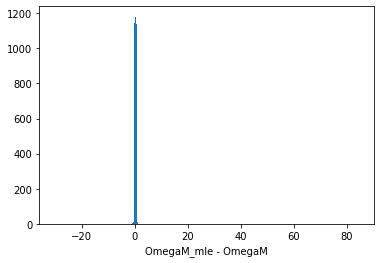

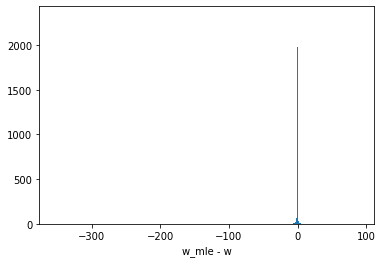

In [179]:
import numpy as onp
theta_true = jnp.array([samples['omegam'], samples['w']]).T[:num]

diff = onp.array(theta_true[:, :2]-pmle_)

mask = (np.abs(diff[:, 0]) < 100)
diff = diff[mask]


plt.hist(diff[:, 0], bins=1000)
#plt.xlim(-1, 1)
plt.xlabel('OmegaM_mle - OmegaM')
plt.show()

plt.hist(diff[:, 1], bins=1000)
#plt.xlim(-1, 1)
plt.xlabel('w_mle - w')
plt.show()

In [11]:
# code adapted from vincent's selection effects work in 2017
import jax.scipy

def codeforA(alpha, beta, n_data=500): 
    A_i = jnp.array([[1., 0., 0.], [0., 1., 0.], [beta, -alpha, 1.]])
    return jax.scipy.linalg.block_diag(*([A_i,]*n_data))

def times_A_from_right(X, alpha, beta):
    X_times_A = jnp.copy(X)
    X_times_A = X_times_A.at[:, ::3].set(X_times_A[:, ::3] + beta*X[:, 2::3])
    X_times_A = X_times_A.at[:, 1::3].set(X_times_A[:, 1::3] - alpha*X[:, 2::3])
    return X_times_A


def times_Atranspose_from_left(X, alpha, beta):
    AT_X = jnp.copy(X)
    AT_X = AT_X.at[::3].set(AT_X[::3] + beta*X[2::3])
    AT_X = AT_X.at[1::3].set(AT_X[1::3] - alpha * X[2::3])
    return AT_X

def codeforsigmaPinv(sigma_res, rc, rx, n_data=500):
    Sinv = jnp.diag(jnp.array([1 / rc**2, 1 / rx**2, 1 / sigma_res**2]))
    return jax.scipy.linalg.block_diag(*([Sinv,]*n_data))

def log_invgamma(x, a, b):
    condition = (x < 1e-3)
    def toosmall(x):
      return -1e90
    def biggerthan(x):
      return jnp.log(b**a) - jax.scipy.special.gammaln(a) + jnp.log(x**(-a - 1) * jnp.exp(-b /x))

    return lax.cond(condition, true_fun=toosmall, false_fun=biggerthan, operand=x)

def log_likelihood(J, sigmaCinv, log_sigmaCinv, param, cosmo_param, data, mu, n_data):
    Zcmb, c, x1, mb = data.T

    Zhel = Zcmb

    alpha, beta, rx, rc, sigma_res = param[:5]
    cstar, xstar, mstar = param[5:8]
    
    # matrices - block diagonal
    A =  codeforA(alpha, beta, n_data)
    sigmaPinv = codeforsigmaPinv(sigma_res, rc, rx, n_data)
    sigmaCinv_A = times_A_from_right(sigmaCinv, alpha, beta)


    # matrices - combinations
    sigmaAinv = times_Atranspose_from_left(sigmaCinv_A, alpha, beta) + sigmaPinv

    #print('is sigmaCinv_A pos def:', is_pos_def(times_Atranspose_from_left(sigmaCinv_A, alpha, beta)))

    X0 = []   # vector of observed values
    for i in range(n_data):
        X0.append(c[i])
        X0.append(x1[i])
        X0.append(mb[i] - mu[i])

    X0 = jnp.array(X0)

    sigmaCinv_X0 = jnp.array(jnp.einsum('ij,j', sigmaCinv, X0)).T # dot sigmaC and X0
    Delta = times_Atranspose_from_left(sigmaCinv_X0, alpha, beta)

    b = jnp.array([[cstar], [xstar], [mstar]])
    Ystar = J @ b  # D doublestar

    # Lower triangular factorized sigmaA
    cho_factorized_sigmaAinv = jax.scipy.linalg.cho_factor(sigmaAinv, lower=True)
    
    Y0 = jnp.array(jax.scipy.linalg.cho_solve(cho_factorized_sigmaAinv, Delta + sigmaPinv @ Ystar))  # kstar
    
    chi1 = jnp.einsum('i,ij,j', jnp.array(X0), sigmaCinv, jnp.array(X0))
    chi2 = Y0.T @ sigmaAinv @ Y0
    chi3 = Ystar.T @ sigmaPinv @ Ystar
    chisquare =  chi1 - chi2 + chi3
    chisquare = jnp.array(chisquare)[0,0]
    
    logdetsigmaPinv = -2 * n_data * jnp.log(rc * rx * sigma_res)
    parta = log_sigmaCinv - 2 * n_data * jnp.log(rc * rx * sigma_res) - 2 * jnp.sum(jnp.log(cho_factorized_sigmaAinv[0].diagonal()))

    # addition of low z anchor
    #lz = 0.01
    #sigma_lz = 0.0135

    #mu_sim = cosmology.muz([0.30, -1, 0.70], lz, lz)
    #mu_fit = cosmology.muz(cosmo_param, lz, lz)
    #anchor = -0.5 * ((mu_sim - mu_fit)**2 / sigma_lz**2) + 1 / (np.sqrt(2 * np.pi) * sigma_lz)

    # INVGAMMA(0.003,0.003) prior distribution on sigma_res^2
    res_prior = log_invgamma(sigma_res**2, 0.003, 0.003)
    
    return -0.5 * (chisquare - parta + 3 * n_data * jnp.log(2 * np.pi)) + res_prior  #+ anchor

In [12]:
import numpy as onp
# old data
# (z,observed_mb,observed_dmb,observed_x1,observed_dx1,observed_c1,observed_dc1,l,b,true_mb,true_x1,true_c)
# new data
# z,obs_mb,obs_dmb,obs_x1,obs_dx1,obs_c1,obs_dc,true_mb,true_x1,true_c
np = onp
def generate_covariance_matrix(data, 
                               save=True, 
                               fname='sim_statssys.txt'):
    obs_dc,obs_dx1,obs_dmb = data[:, 6].T, data[:, 4].T, data[:, 2].T
    cov_data = onp.zeros((onp.shape(data)[0]*3,onp.shape(data)[0]*3)) # Assume diagonal covariance
    for i in range(0,onp.shape(data)[0]):
        cov_data[i*3][i*3] = obs_dc[i] ** 2.0 # Set c value
        cov_data[i*3 + 1][i*3 + 1] = obs_dx1[i] ** 2.0# Set x value
        cov_data[i*3 + 2][i*3 + 2] = obs_dmb[i] ** 2.0# Set mb value
    
    if save:
      np.savetxt(fname, cov_data, delimiter=' ')
    return cov_data

In [13]:
key=jax.random.PRNGKey(9)

In [14]:
# create fiducial sim
#omegam, w, alpha, beta, M_0, sigma_res, x1_mean, x1_std, c_mean, c_std = theta
# truths = [0.3, -1.0, 0.13, 2.56, -19.3, 0.1, 0.0, 1.0, 0.0, 0.1]
theta_fid = jnp.array([0.3, -1.0, 0.13, 2.56, -19.3, 0.1, 0.0, 1.0, 0.0, 0.1])

fiducial_sim = generate_sn1a(key, theta_fid, n_data=100)

fiducial_cov = generate_covariance_matrix(fiducial_sim)

In [15]:
def get_cov(dc,dx1,dmb,n_data):
  diag_ = jnp.zeros((n_data*3,))
  for i in range(n_data):
    diag_ = diag_.at[i*3:(i+1)*3].set(jnp.array([dc[i]**2,dx1[i]**2, dmb[i]**2]))
  return jnp.diag(diag_)

In [24]:
# UNPACK DATA CORRECTLY
z,obs_mb,obs_dmb,obs_x1,obs_dx1,obs_c,obs_dc,true_mb,true_x1,true_c = fiducial_sim.T

data = jnp.stack([z, obs_c, obs_x1, obs_mb])

In [33]:
from jax.config import config
config.update("jax_debug_nans", True)

In [45]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [46]:
is_pos_def(sigmaC)

True

In [16]:
#data = np.array(datalist)  # now the data is the same length as the covariance cube diagonal

# z,obs_mb,obs_dmb,obs_x1,obs_dx1,obs_c,obs_dc,true_mb,true_x1,true_c

# Zcmb, c, x1, mb = data.T


# UNPACK DATA CORRECTLY
z,obs_mb,obs_dmb,obs_x1,obs_dx1,obs_c,obs_dc,true_mb,true_x1,true_c = fiducial_sim.T

data = jnp.stack([z, obs_c, obs_x1, obs_mb]).T


# number of SNe with invertible covariances (only small fraction don't)
#num_sn = len(sn_cube)
# set how big each SN's covariance block will be
#blocksize = len(sn_cube[1])
# set up empty cov cube
#side_len = num_sn*blocksize
#bigcube = np.zeros((side_len, side_len))
# fill cov cube diagonals with each SN covariance block
#for i in range(num_sn):    
#    bigcube[i*blocksize:(i+1)*blocksize, i*blocksize:(i+1)*blocksize] = np.array(sn_cube[i])

# put in terms of Evan's code

n_data = len(data)

def get_cov(dc,dx1,dmb,n_data):
  diag_ = jnp.zeros((n_data*3,))
  for i in range(n_data):
    diag_ = diag_.at[i*3:(i+1)*3].set(jnp.array([dc[i]**2,dx1[i]**2, dmb[i]**2]))
  return jnp.diag(diag_)

#sigmaC = fiducial_cov
sigmaC = get_cov(obs_dc, obs_dx1, obs_dmb, n_data)

log_sigmaCinv = (-1 * jnp.linalg.slogdet(sigmaC)[1])
sigmaCinv = jnp.linalg.inv(sigmaC)



J = []
for i in range(n_data):
    J.append([1., 0., 0.])
    J.append([0., 1., 0.])
    J.append([0., 0., 1.])
J  = jnp.array(J)


# cosmo_param = param[8:11]
# param = param[:8]



#omegam, w, alpha, beta, M_0, sigma_res, x1_mean, x1_std, c_mean, c_std = theta
# truths = [0.3, -1.0, 0.13, 2.56, -19.3, 0.1, 0.0, 1.0, 0.0, 0.1]

# ordering for log_like function
#     alpha, beta, rx, rc, sigma_res = param[:5]
#    cstar, xstar, mstar = param[5:8]

param = jnp.array([0.13, 2.56, 1.0, 0.1, 0.1, 0.0, 0.0, -19.3])
cosmo_param = jnp.array([0.3, -1.0])

#z = data.T[0]
omegam, w = cosmo_param

mu_i = muz(omegam, w, z)

log_likelihood(J, sigmaCinv, log_sigmaCinv, param, cosmo_param, data, mu_i, n_data)



DeviceArray(96893512., dtype=float32)

## now vmap the whole bloody thing

In [17]:
def map_likelihood(cosmo_param, theta, data, ):

    # UNPACK DATA CORRECTLY
    z,obs_mb,obs_dmb,obs_x1,obs_dx1,obs_c,obs_dc,true_mb,true_x1,true_c = data.T

    data = jnp.stack([z, obs_c, obs_x1, obs_mb]).T

    # put in terms of Evan's code
    n_data = len(data)

    def get_cov(dc,dx1,dmb,n_data):
      diag_ = jnp.zeros((n_data*3,))
      for i in range(n_data):
        diag_ = diag_.at[i*3:(i+1)*3].set(jnp.array([dc[i]**2,dx1[i]**2, dmb[i]**2]))
      return jnp.diag(diag_)

    #sigmaC = fiducial_cov
    sigmaC = get_cov(obs_dc, obs_dx1, obs_dmb, n_data)

    log_sigmaCinv = (-1 * jnp.linalg.slogdet(sigmaC)[1])
    sigmaCinv = jnp.linalg.inv(sigmaC)


    J = []
    for i in range(n_data):
        J.append([1., 0., 0.])
        J.append([0., 1., 0.])
        J.append([0., 0., 1.])
    J  = jnp.array(J)


    #param = jnp.array([0.13, 2.56, 1.0, 0.1, 0.1, 0.0, 0.0, -19.3])
    #cosmo_param = jnp.array([0.3, -1.0])

    alpha, beta, M_0, sigma_res, x1_mean, x1_std, c_mean, c_std = theta
    param = jnp.array([alpha, beta, x1_std, c_std, sigma_res, x1_mean, c_mean, M_0])

    #z = data.T[0]
    omegam, w = cosmo_param

    mu_i = muz(omegam, w, z)

    return log_likelihood(J, sigmaCinv, log_sigmaCinv, param, cosmo_param, data, mu_i, n_data) #/ 1e7


In [19]:
num=100
keys = jax.random.split(key, num=num)
sims = jax.vmap(generate_sn1a)(keys, theta_[:num])

cosmo_params = theta_[:num, :2]
rest_thetas = theta_[:num, 2:]

#jax.vmap(map_likelihood)(cosmo_params, rest_thetas, sims)
scores_ = jax.vmap(jax.jacrev(map_likelihood, argnums=0))(cosmo_params, rest_thetas, sims)

In [20]:
scores_

DeviceArray([[-1.03246172e+05, -8.87853711e+03],
             [-1.07363120e+07, -8.39987188e+05],
             [-1.54876220e+07, -2.82421100e+06],
             [ 5.03743688e+05,  2.51135469e+05],
             [ 1.60870862e+06,  5.30201562e+05],
             [-3.15742875e+06, -3.69368906e+05],
             [-7.16760812e+05, -4.27071000e+05],
             [-2.82040150e+06, -2.00212212e+06],
             [-1.26380480e+07, -1.92014550e+06],
             [-1.32834225e+06, -1.79424288e+06],
             [ 2.07915703e+05,  2.57213375e+05],
             [-9.43118400e+06, -1.25180575e+06],
             [-2.35720920e+07, -1.77649780e+07],
             [-3.94830500e+06, -1.45490850e+06],
             [ 2.07054650e+06,  3.35360906e+05],
             [ 3.78102750e+05,  6.99956719e+04],
             [-3.87652040e+07, -8.17376400e+06],
             [ 1.02427456e+08,  2.28777980e+07],
             [-1.02936080e+07, -4.72622750e+05],
             [-1.33389203e+05, -9.65309219e+04],
             [ 5.048

In [171]:
Fs_ = -jax.vmap(jax.jacfwd(jax.jacrev(map_likelihood, argnums=0)))(cosmo_params, rest_thetas, sims)

In [172]:
Fs_[10]

DeviceArray([[-3.1045654e+02, -1.1193479e+06],
             [-1.1193476e+06,  1.8650941e+05]], dtype=float32)

In [173]:
theta_fid_ = jnp.array([0.3, -1.0])
big_Fs = Fs_ + jnp.eye(2)
pmle_ = theta_fid_ + jnp.einsum('ijk,ik->ij', jnp.linalg.inv(big_Fs), scores_)

In [168]:
sims.shape

(50, 500, 10)

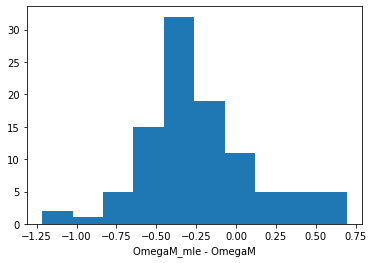

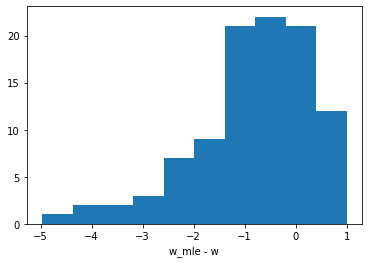

In [174]:
import numpy as onp
theta_true = cosmo_params

diff = onp.array(theta_true[:, :2]-pmle_)

#mask = (np.abs(diff[:, 0]) < 100)
#diff = diff[mask]


plt.hist(diff[:, 0])
#plt.xlim(-1, 1)
plt.xlabel('OmegaM_mle - OmegaM')
plt.show()

plt.hist(diff[:, 1])
#plt.xlim(-1, 1)
plt.xlabel('w_mle - w')
plt.show()

In [176]:
theta_.shape

(1000000, 10)

In [86]:
sfiducial_sim.shape

(50, 10)

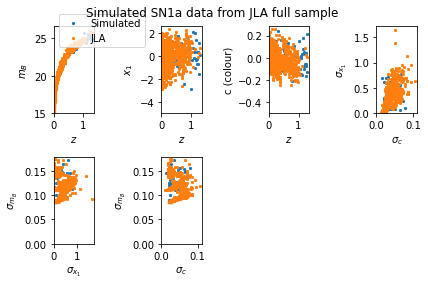

In [18]:
make_plot(fiducial_sim.T)

In [ ]:
fiducial_cov.shape

(150, 150)

In [ ]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
import torch
import jax
from jax import lax
import jax_cosmo as jc
import scipy.constants as cnst

import matplotlib.pyplot as plt

In [ ]:
inference_type = 'w'

# define auto-differentiable cosmology functions in `jax-cosmo`

In [ ]:
# the integrand in the calculation of mu from z,cosmology
@jit
def integrand(zba, omegam, omegade, w):
    return 1.0/np.sqrt(
        omegam*(1+zba)**3 + omegade*(1+zba)**(3.+3.*w) + (1.-omegam-omegade)*(1.+zba)**2
    )

# integration of the integrand given above, vmapped over z-axis
@jit
def hubble(z,omegam, omegade,w):
    # method for calculating the integral
    myfun = lambda z: jc.scipy.integrate.romb(integrand,0., z, args=(omegam,omegade,w)) #[0]
    I = jax.vmap(myfun)(z)
    return I


@jit
def Dlz(omegam, omegade, h, z, w, z_helio):

    # which inference are we doing ?
    if inference_type == "omegade":
      omegakmag =  np.sqrt(np.abs(1-omegam-omegade))  
    else:
      omegakmag = 0.

    hubbleint = hubble(z,omegam,omegade,w)
    condition1 = (omegam + omegade == 1) # return True if = 1 
    condition2 = (omegam + omegade > 1.)

    #if (omegam+omegade)>1:
    def ifbigger(omegakmag):
      return (cnst.c*1e-5 *(1+z_helio)/(h*omegakmag)) * np.sin(hubbleint*omegakmag)

    # if (omegam+omegade)<1:
    def ifsmaller(omegakmag):
      return cnst.c*1e-5 *(1+z_helio)/(h*omegakmag) *np.sinh(hubbleint*omegakmag)   

    # if (omegam+omegade==1):
    def equalfun(omegakmag):
      return cnst.c*1e-5 *(1+z_helio)* hubbleint/h

    # if not equal, default to >1 condition
    def notequalfun(omegakmag):
      return lax.cond(condition2, true_fun=ifbigger, false_fun=ifsmaller, operand=omegakmag)

    distance = lax.cond(condition1, true_fun=equalfun, false_fun=notequalfun, operand=omegakmag)

    return distance


# muz: distance modulus as function of params, redshift
@jit
def muz(omegam, w, z):
    z_helio = z # should this be different ?
    omegade = 1. - omegam
    #w = -1.0 # freeze w
    h = 0.72
    return (5.0 * np.log10(Dlz(omegam, omegade, h, z, w, z_helio))+25.)

# plot $mu(z)$ at fiducial model

time to compute 500 SNIa distance integrals:


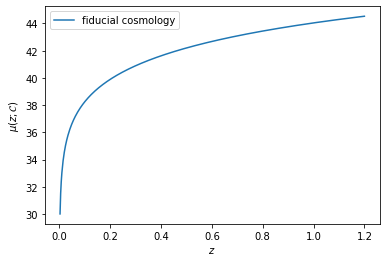

In [ ]:
zs = np.linspace(0, 1.2, num=500)
print('time to compute 500 SNIa distance integrals:')
mymus = muz(0.3, -1.0, zs)
plt.plot(zs, mymus, label='fiducial cosmology')

plt.xlabel(r'$z$')
plt.ylabel(r'$\mu(z; \mathcal{C})$')
plt.legend()
plt.show()

# build our sampler

In [ ]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, HMC

In [ ]:
@jit
def log_uniform(r, log_min_val, log_max_val):
    """log-uniform prior
      given point sampled from unif(0, 1)
      return point sampled on a uniform log scale from min_val to max_val
      """
    #log_min_val = np.log10(min_val)
    #log_max_val = np.log10(max_val)
    point = 10.0 ** (log_min_val + r * (log_max_val - log_min_val))

    return point

### the bahamas model 
in < 25 lines of code !

In [ ]:
d = dist.TransformedDistribution(dist.Uniform(-3.0, 0.0), dist.transforms.ExpTransform())

In [ ]:
d.sample(key, (10,))

DeviceArray([0.42156112, 0.15269667, 0.16137482, 0.48187065, 0.24222465,
             0.07379443, 0.2784447 , 0.11235794, 0.4448508 , 0.5804892 ],            dtype=float32)

In [ ]:
## define bahamas HMC model
#np = jnp
def bahamas(z, data, Cov, snID, ndat):


    # globals
    OmM = numpyro.sample('OmM', dist.Uniform(low=0.0, high=1.0))
    w = numpyro.sample('w', dist.Uniform(low=-2.0, high=0.0))
    #OmDE = numpyro.sample('OmDE', dist.Uniform(low=0.0, high=2.0)) # for OmDE inference

    α = numpyro.sample('α', dist.Uniform(0.0, 1.0))
    β = numpyro.sample('β', dist.Uniform(0.0, 4.0))

    # mB hypers
    #σ_res_sq = numpyro.sample('σ_res_sq', dist.InverseGamma(ndat/2, 1.0 + 0.003))
    #σ_res_sq = numpyro.sample('σ_res_sq', dist.InverseGamma(0.003, 0.003))
    #σ_res = numpyro.sample('σ_res', dist.Uniform())
    #σ_res = log_uniform(σ_res, -3.0, 0.0)
    σ_res =  numpyro.sample('σ_res', dist.TransformedDistribution(
                      dist.Uniform(-3.0, 0.0), 
                      dist.transforms.ExpTransform()))

    M0 = numpyro.sample('M0', dist.Normal(-19.3, 2.0))
    # stretch hypers
    xstar = numpyro.sample('xstar', dist.Normal(loc=0.0,scale=0.1))
    #_rx = numpyro.sample('_rx', dist.Uniform())
    #Rx =  log_uniform(_rx, -5.0, 2.0)
    Rx =  numpyro.sample('Rx', dist.TransformedDistribution(
                      dist.Uniform(-5.0, 2.0), 
                      dist.transforms.ExpTransform()))
    # color hypers
    cstar = numpyro.sample('cstar', dist.Normal(loc=0.0,scale=0.1))
    #_rc = numpyro.sample('Rc', dist.Uniform())
    #Rc = log_uniform(_rc, -5.0, 2.0)

    Rc = numpyro.sample('Rc', dist.TransformedDistribution(
                      dist.Uniform(-5.0, 2.0), 
                      dist.transforms.ExpTransform()))
    


    unique_sn_IDs = snID
    n_sne = len(unique_sn_IDs)

    # now latents

    with numpyro.plate("plate_i", n_sne) as idx:
        c_ = numpyro.sample('c', dist.Normal(cstar, Rc))
        x1_ = numpyro.sample('x1', dist.Normal(xstar, Rx))
        M_ = numpyro.sample('M', dist.Normal(M0, σ_res))
   

    # compute mB [IMPORTANT BIT]
    mB_ = muz(OmM, w, z[snID]) - α*x1_[snID] + β*c_[snID] + M_[snID]

    
   # do the selection function thing
   # feed [mB, x1, c, z, I] -> logreg function -> I
   # ... DELFI p(I|theta)
   # Lcorr = Lvanilla * prod p(I | D, z) / p(I | theta)

    # assemble means for obs variable draw
    _obsloc = np.stack((c_,x1_,mB_), axis=1)

    # now sample observed values with measured covariance
    with numpyro.plate("plate_i", n_sne): #as idx:
        numpyro.sample('obs', dist.MultivariateNormal(_obsloc, Cov), obs=data)


In [ ]:
bahamas.log_prob

AttributeError: ignored

In [ ]:
import pandas as pd
import numpy as onp
import jax.numpy as jnp
np = jnp

#datafname = 'lc_params.txt'

# use simulated data
headings = ["z","mb","obs_dmb","obs_x1","x1","c","obs_dc","true_mb","true_x1","true_c"]

datadf = pd.DataFrame(data=onp.array(fiducial_sim), columns=headings)

#names = ['z', 'c', 'x1', 'mb']
#data = np.array([fiducial_sim[:, 5], fiducial_sim[:, 3], fiducial_sim[:, 1]])
z = datadf["z"].values

data = np.array(datadf[['c', 'x1', 'mb']])
ndat = len(data)

# unpack block diags
sigmaC = onp.array(onp.loadtxt('sim_statssys.txt'))
M = int(3)
covs = np.array([sigmaC[i*M:(i+1)*M,i*M:(i+1)*M] for i in range(sigmaC.shape[0]//M)])

ID = np.arange(ndat)

In [ ]:
data.shape

(50, 3)

In [ ]:
np.std(datadf["obs_x1"].values)

DeviceArray(1.1344041, dtype=float32)

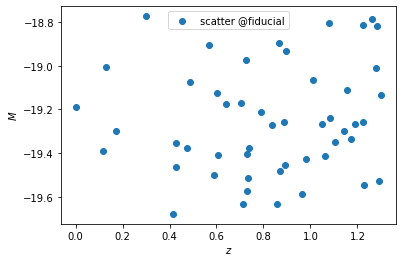

In [ ]:
# plot truth just to be sure
true_alpha = 0.13
true_beta = 2.56
true_omegam = 0.3
true_w = -1.0
#true_omegade = 0.6

# mB_ = muz(OmM, w, z[snID]) - α*x1_[snID] + β*c_[snID] + M_[snID]

myM = datadf["mb"] - muz(true_omegam, true_w, z) + true_alpha*datadf["x1"] - true_beta*datadf["c"]
plt.scatter(z, myM, label='scatter @fiducial')

plt.xlabel(r'$z$')
plt.ylabel(r'$M$')
plt.legend()
plt.show()

## run sampler

In [ ]:
ndat

50

In [ ]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
kernel = NUTS(bahamas, target_accept_prob=0.75)
              #init_strategy=numpyro.infer.init_to_value(values={"OmM": 0.3}))
mcmc = MCMC(kernel, num_warmup=1000, num_samples=800)
mcmc.run(rng_key_, z=z, data=data, Cov=covs, snID=ID, ndat=ndat)
mcmc.print_summary()

sample: 100%|██████████| 1800/1800 [07:19<00:00,  4.10it/s, 63 steps of size 4.61e-02. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      M[0]    -19.39      0.19    -19.39    -19.72    -19.08     49.03      1.01
      M[1]    -19.41      0.18    -19.41    -19.71    -19.12    121.49      1.01
      M[2]    -19.13      0.19    -19.14    -19.44    -18.83     90.19      1.01
      M[3]    -19.38      0.16    -19.38    -19.61    -19.13     78.55      1.02
      M[4]    -19.19      0.17    -19.19    -19.44    -18.88    120.20      1.01
      M[5]    -19.42      0.18    -19.43    -19.69    -19.12    211.29      1.01
      M[6]    -19.06      0.18    -19.06    -19.38    -18.79    112.01      1.00
      M[7]    -19.42      0.15    -19.41    -19.67    -19.16    108.12      1.00
      M[8]    -18.98      0.18    -18.98    -19.23    -18.67    108.45      1.00
      M[9]    -19.27      0.16    -19.27    -19.54    -19.02    110.25      1.01
     M[10]    -19.17      0.18    -19.17    -19.45    -18.89    179.12      1.01
     M[11]    -19.14      0

In [ ]:
log_uniform(samples['σ_res'], -3.0, 0.0)

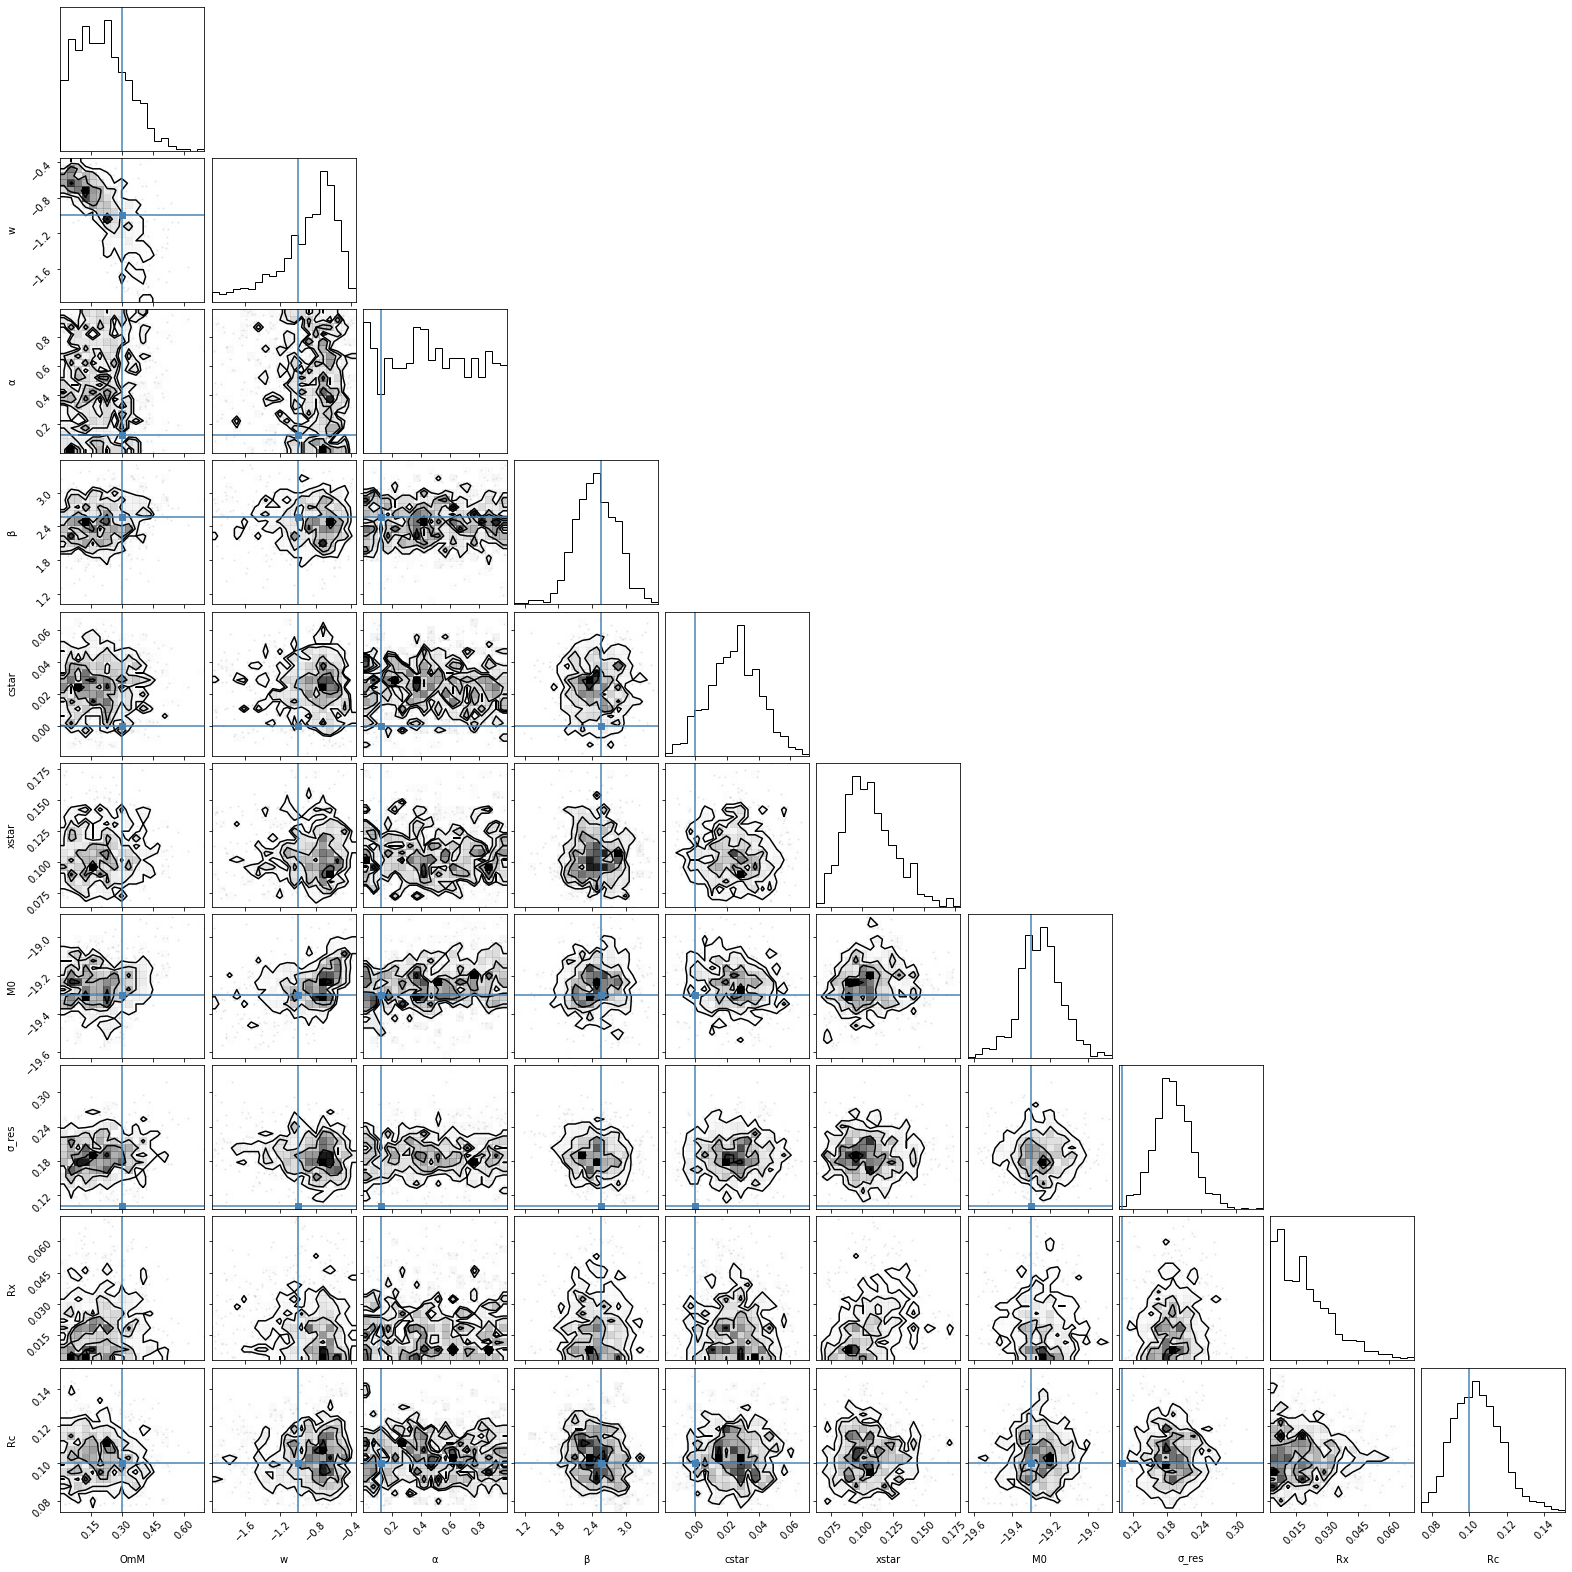

In [ ]:
import corner

samples = mcmc.get_samples()
labels = ['OmM', 'w', 'α', 'β', 'cstar', 'xstar', 'M0', 'σ_res', 'Rx', 'Rc'] #list(samples.keys())

#samples['σ_res'] = log_uniform(samples['σ_res'], -3.0, 0.0)

truths = [0.3, -1.0, 0.13, 2.56, 0.0, 0.0, -19.3, 0.1, 1.0, 0.1]

#omM, omDE = samples['cosmo'].T

flat_samples = onp.stack([samples[lab] for lab in labels]).T #np.stack(list([omM, omDE]), axis=1)
OmM_true, OmDE_true = 0.3, -1.0

fig = corner.corner(
    flat_samples, labels=labels, truths=truths
);

# check model latents
Now that we've run our inference, we can take a look at how our model did. First compare latents to plug-in estimates for various quantities

In [ ]:
datafname = 'lc_params.txt'

# load data 

names = ['z', 'c', 'x1', 'mb']
datadf = pd.read_csv(datafname, header=0, sep='\s+', usecols=names)
z = datadf['z'].values

# unpack block diags
sigmaC = onp.array(onp.loadtxt('sim_statssys.txt'))
M = int(3)
covs = np.array([sigmaC[i*M:(i+1)*M,i*M:(i+1)*M] for i in range(sigmaC.shape[0]//M)])

# compute mus for each SN
_OmM = np.mean(samples['OmM'])
_w = np.mean(samples['w'])
_beta = np.mean(samples['β'])
_alpha = np.mean(samples['α'])

_mus = muz(_OmM, _w, z) - _alpha*datadf['x1'].values + _beta*datadf['c'].values

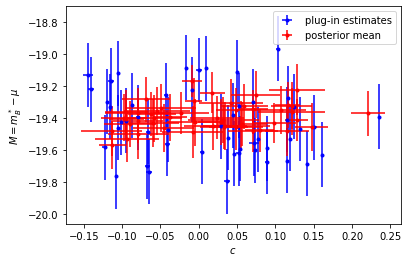

In [ ]:
cobserr = [covs[i][0, 0] for i in range(len(covs))]
plt.errorbar(datadf['c'],
             datadf['mb'] - _mus,
             yerr = np.std(datadf['mb'].values - _mus, axis=0),fmt='.',
             xerr = cobserr, c='b', label='plug-in estimates')

plt.errorbar(np.mean(samples['c'], axis=0),
             np.mean(samples['M'], axis=0),
             yerr = np.std(samples['M'], axis=0),fmt='.',
             xerr = np.std(samples['c'], axis=0), c='r', label='posterior mean')

plt.ylabel(r"$M = m^*_B - \mu$")
plt.xlabel(r'$c$')
plt.legend()

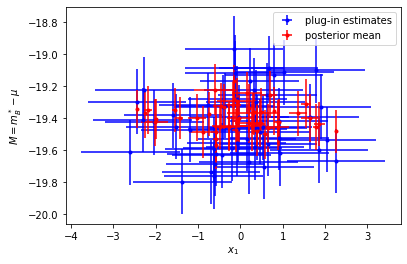

In [ ]:
x1obserr = [covs[i][1, 1] for i in range(len(covs))]
plt.errorbar(datadf['x1'],
             datadf['mb'] - _mus,
             yerr = np.std(datadf['mb'].values - _mus, axis=0), fmt='.',
             xerr = np.std(datadf['x1'].values, axis=0), c='b', label='plug-in estimates')

plt.errorbar(np.mean(samples['x1'], axis=0),
             np.mean(samples['M'], axis=0),
             yerr = np.std(samples['M'], axis=0), fmt='.',
             xerr = x1obserr, c='r', label='posterior mean')

plt.ylabel(r"$M = m^*_B - \mu$")
plt.xlabel(r'$x_1$')
plt.legend()

We observe that using the posterior mean of latents for residual $M_i$ calculation reduces spread with respect to $c$ and $x_1$ light curve parameters.

# the money plot
Isolate the corner for $\Omega_m$-$w$ inference

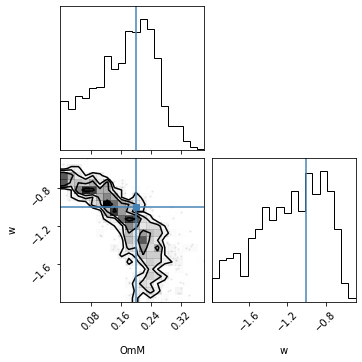

In [ ]:
samples = mcmc.get_samples()
labels = ['OmM', 'w'] #list(samples.keys())

truths = [0.2, -1.0]

#omM, omDE = samples['cosmo'].T

flat_samples = onp.stack([samples[lab] for lab in labels]).T #np.stack(list([omM, omDE]), axis=1)
OmM_true, OmDE_true = 0.3, -1.0

fig = corner.corner(
    flat_samples, labels=labels, truths=truths
);